In [ ]:
import torch.nn as nn
import torch.nn.init as init

import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

In [ ]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64*block.expansion, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet68():
    return ResNet(BasicBlock, [11, 11, 11])

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA Start!")
else:
    device = torch.device('cpu')
    print("Using CPU")

net = ResNet68()
net = net.to(device)

CUDA Start!


In [ ]:
# Define transformations for data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# Define batch sizes
train_batch_size = 64  # Reduced batch size
test_batch_size = 64  # Reduced batch size

In [ ]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Lists to store final results of each epoch
train_accuracies = []
test_accuracies= []
train_losses = []
test_losses = []

# Training function
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    # #Defining learning rate
    # if epoch < warmup_epochs:
    #     # Adjust learning rate for warm-up epochs
    #     warmup_factor = (epoch + 1) / warmup_epochs
    #     curr_lr = warmup_lr_init + (warmup_lr_final - warmup_lr_init) * warmup_factor
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = curr_lr
    # else:
    #     # Revert to original learning rate after warm-up
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = warmup_lr_final

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Calculate and save final accuracy for this epoch
    train_accuracy = 100. * correct / total
    train_accuracies.append(train_accuracy)

    train_loss /= len(trainloader)  # Average loss per batch
    train_losses.append(train_loss)

    print("train accuracy: ", train_accuracy)
    print("train loss: ", train_loss)

# Testing function
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Calculate and save final accuracy for this epoch
    test_accuracy = 100. * correct / total
    test_accuracies.append(test_accuracy)
    test_loss /= len(testloader)  # Average loss per batch
    test_losses.append(test_loss)

    print("test accuracy: ", test_accuracy)
    print("test loss: ", test_loss)



In [ ]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [ ]:
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train accuracy:  35.532
train loss:  1.7703219482965786
test accuracy:  51.1
test loss:  1.3821087726362191

Epoch: 1
train accuracy:  53.044
train loss:  1.3023951265513134
test accuracy:  59.92
test loss:  1.128989104252712

Epoch: 2
train accuracy:  61.53
train loss:  1.0808293226429873
test accuracy:  63.09
test loss:  1.0588979436333772

Epoch: 3
train accuracy:  67.16
train loss:  0.9346146753910557
test accuracy:  65.7
test loss:  1.0048029358219948

Epoch: 4
train accuracy:  70.628
train loss:  0.8345660863020231
test accuracy:  69.57
test loss:  0.9003689482713201

Epoch: 5
train accuracy:  73.94
train loss:  0.7452318467523741
test accuracy:  74.42
test loss:  0.7415300907602735

Epoch: 6
train accuracy:  76.378
train loss:  0.683434475032265
test accuracy:  75.5
test loss:  0.7186958751860698

Epoch: 7
train accuracy:  78.236
train loss:  0.6283918646976466
test accuracy:  77.07
test loss:  0.6803043144903366

Epoch: 8
train accuracy:  79.536
train loss:  0.5858416350753716


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Final Accuracy on Test Dataset: {:.2f}%'.format(accuracy))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Final Accuracy on Test Dataset: 90.14%


In [ ]:
import matplotlib.pyplot as plt

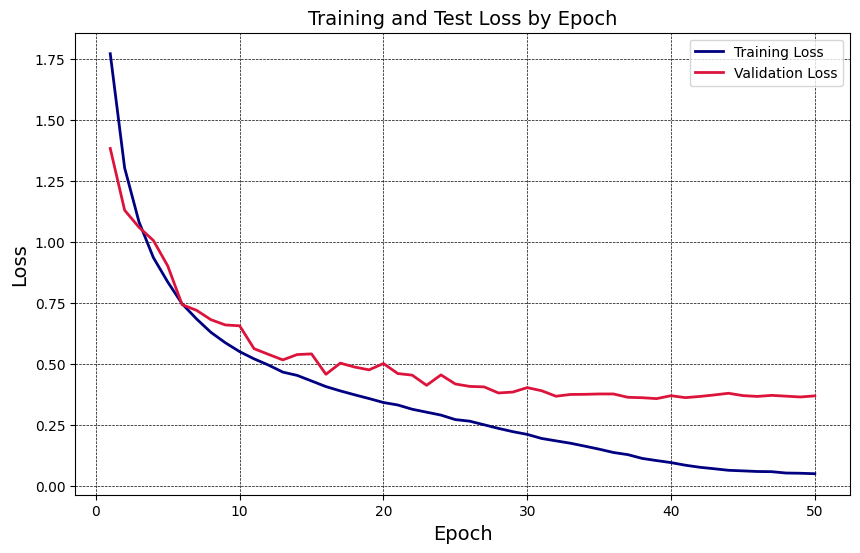

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
epochs = range(1, 51)

# Plotting the training loss
train_line, = ax.plot(epochs, train_losses[:50], label='Training Loss', color='navy', linewidth=2)

# Plotting the validation loss
test_line, = ax.plot(epochs, test_losses[:50], label='Validation Loss', color='crimson', linewidth=2)

ax.set_title('Training and Test Loss by Epoch', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(handles=[train_line, test_line], loc='upper right')
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='black')
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.show()

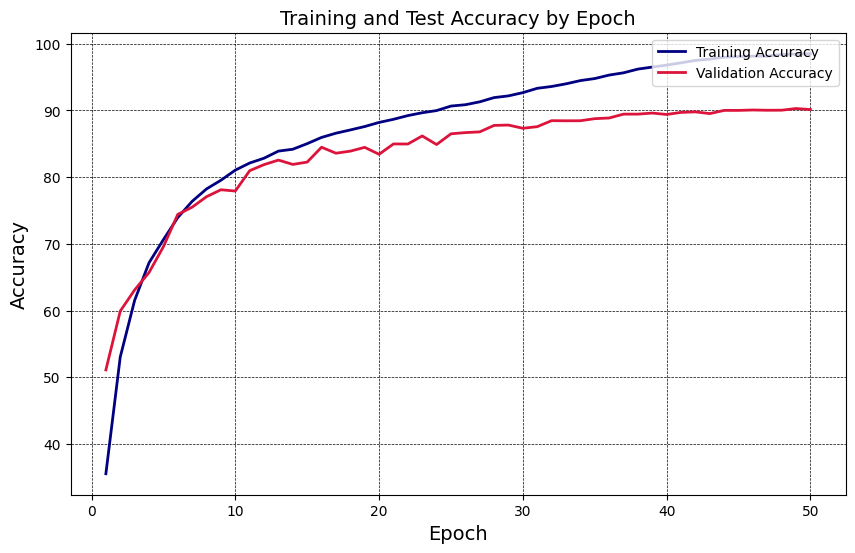

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
epochs = range(1, 51)

# Plotting the training loss
train_line, = ax.plot(epochs, train_accuracies, label='Training Accuracy', color='navy', linewidth=2)

# Plotting the validation loss
test_line, = ax.plot(epochs, test_accuracies, label='Validation Accuracy', color='crimson', linewidth=2)

ax.set_title('Training and Test Accuracy by Epoch', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(handles=[train_line, test_line], loc='upper right')
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='black')
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.show()